In [45]:
import syndat
import os
import numpy as np
from matplotlib.pyplot import *
# import nuctools as nuc
import pandas as pd
import scipy.linalg as spla

In [46]:
%matplotlib widget

### This notebook uses the syndat program to create a synthetic realization of the Ta181 transmission data set using ENDF parameters and verifies the results against real data reduced by Brown, et. al.

Because the we are using the endf evaluated parameters, we are skipping the steps to generate resonance paremeters and theoretical tranmission with syndat. Rather, we will just read out the sammy calculated endf cross section and take that as the true theoretical cross section.

In [47]:
# import Jesse's reduced data and look at it
jb_df = pd.read_csv("../synthetic_data/Ta181/JB_sol/JB_reduction_data.csv", index_col='Unnamed: 0')
jb_cov = np.load("../synthetic_data/Ta181/JB_sol/JB_cov.npy")
jb_df

,e,trans,tof,cs,dcs,bs,dbs,co,dco,bo,dbo,bfit
0,88416.045425,0.571458,11.8816,580.950003,6.195396,187.842997,0.1,1166.229542,12.078151,478.327440,0.1,3.160622e+02
1,73637.283950,0.538982,12.7008,1814.838405,10.950114,180.492386,0.1,3491.405805,20.898187,459.121847,0.1,3.030060e+02
2,62276.564917,0.520194,13.5200,1959.652939,11.378611,173.445420,0.1,3874.441705,22.014712,440.709615,0.1,2.904892e+02
3,53355.681453,0.531282,14.3392,1707.443607,10.621182,166.689556,0.1,3323.128704,20.388347,423.057969,0.1,2.784894e+02
4,46222.889688,0.502918,15.1584,1241.464506,9.056634,160.212768,0.1,2556.093274,17.881205,406.135492,0.1,2.669854e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
15910,3.015622,0.417764,1468.1888,18.485957,1.105149,9.900000,0.1,33.952195,2.060831,13.400000,0.1,8.506101e-31
15911,3.012251,0.349083,1469.0080,17.332079,1.070102,9.900000,0.1,34.690271,2.083110,13.400000,0.1,8.154724e-31
15912,3.008887,0.297559,1469.8272,15.890513,1.024634,9.900000,0.1,33.532182,2.048044,13.400000,0.1,7.817863e-31
15913,3.005528,0.500051,1470.6464,18.931344,1.118383,9.900000,0.1,31.460858,1.983781,13.400000,0.1,7.494916e-31


In [48]:
opendata = '../synthetic_data/Ta181/rpi-open-ta181.csv'
sammy_xs = '../synthetic_data/Ta181/jeff_eval/SAMMY.LST' #'../synthetic_data/Ta181/endf_eval/SAMMY.LST'

# JBrown_lst = syndat.sammy_interface.readlst('../synthetic_data/Ta181/JB_sol/SAMMY_JBsol.LST')
# # calc tof using t0 and distance
# JBrown_lst['tof'] = syndat.exp_effects.e_to_t(JBrown_lst.E, 35.185, True)*1e6+3.326



In [49]:
# generation/reduction options
perform_methods = True
add_noise = True
default_exp = True

experiment = syndat.experiment(perform_methods, default_exp, add_noise, opendata, sammy_xs, E_limits=(3,100000))
# experiment.get_odat(opendata)


FileNotFoundError: [Errno 2] No such file or directory: '../synthetic_data/Ta181/jeff_eval/SAMMY.LST'

In [ ]:

experiment.odat

,tof,bin_width,c,dc,E,bw,cps,dcps
0,11.8816,0.8192,9323.24616,96.556958,88416.046104,8.192000e-07,1165.985442,12.075623
1,12.7008,0.8192,27911.51706,167.067403,73637.284515,8.192000e-07,3490.675029,20.893813
2,13.5200,0.8192,30973.63978,175.993295,62276.565395,8.192000e-07,3873.630756,22.010104
3,14.3392,0.8192,26566.25116,162.991568,53355.681863,8.192000e-07,3322.433149,20.384080
4,15.1584,0.8192,20434.30211,142.948600,46222.890043,8.192000e-07,2555.558265,17.877463
...,...,...,...,...,...,...,...,...
15910,1468.1888,0.8192,271.42570,16.475002,3.015622,8.192000e-07,33.945088,2.060400
15911,1469.0080,0.8192,277.32614,16.653112,3.012251,8.192000e-07,34.683010,2.082674
15912,1469.8272,0.8192,268.06797,16.372781,3.008887,8.192000e-07,33.525163,2.047616
15913,1470.6464,0.8192,251.50908,15.859038,3.005528,8.192000e-07,31.454273,1.983366


In [ ]:
# put eveything in a similarly structured dataframe
syndat_df = pd.DataFrame({
    'e' : experiment.odat.E,
    'trans': experiment.trans.exp_trans,
    'theo': experiment.trans.theo_trans,
    'tof': experiment.trans.tof,
    'cs' : experiment.sdat.cps,
    'dcs': experiment.sdat.dcps,
    'bs' : experiment.redpar.val.ks*experiment.Bi+experiment.redpar.val.b0s,
    'dbs': np.array([0.1]*len(experiment.odat.E)),
    'co' : experiment.odat.cps,
    'dco': experiment.odat.dcps,
    'bo' : experiment.redpar.val.ko*experiment.Bi+experiment.redpar.val.b0o,
    'dbo': np.array([0.1]*len(experiment.odat.E))
    # 'bfit': exp_f(trans1.open_data.tof,A,B)
})
syndat_df= syndat_df[::-1].reset_index(drop=True)
eLimits = (3,100000)
syndat_df = syndat_df[(syndat_df.e>eLimits[0])&(syndat_df.e<eLimits[1])].reset_index(drop=True)
syndat_df.sort_values('tof', inplace=True)
display(syndat_df)


,e,trans,theo,tof,cs,dcs,bs,dbs,co,dco,bo,dbo
15914,88416.046104,0.441566,0.430163,11.881600,491.494347,7.840112,187.811774,0.1,1165.985442,12.075623,478.245861,0.1
15913,73637.284515,0.431542,0.424689,12.700800,1488.740130,13.644965,180.459799,0.1,3490.675029,20.893813,459.036704,0.1
15912,62276.565395,0.420445,0.420419,13.520000,1616.803797,14.219740,173.411635,0.1,3873.630756,22.010104,440.621340,0.1
15911,53355.681863,0.408572,0.417003,14.339200,1351.296800,12.999851,166.654727,0.1,3322.433149,20.384080,422.966968,0.1
15910,46222.890043,0.415895,0.414207,15.158400,1054.149072,11.481906,160.177039,0.1,2555.558265,17.877463,406.042140,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
4,3.015622,0.187726,0.154195,1468.188682,13.756839,1.311663,9.900000,0.1,33.945088,2.060400,13.400000,0.1
3,3.012251,0.134208,0.155063,1469.008106,12.756342,1.263066,9.900000,0.1,34.683010,2.082674,13.400000,0.1
2,3.008887,0.129500,0.155926,1469.827230,12.506217,1.250622,9.900000,0.1,33.525163,2.047616,13.400000,0.1
1,3.005528,0.158209,0.156786,1470.646456,12.756342,1.263066,9.900000,0.1,31.454273,1.983366,13.400000,0.1


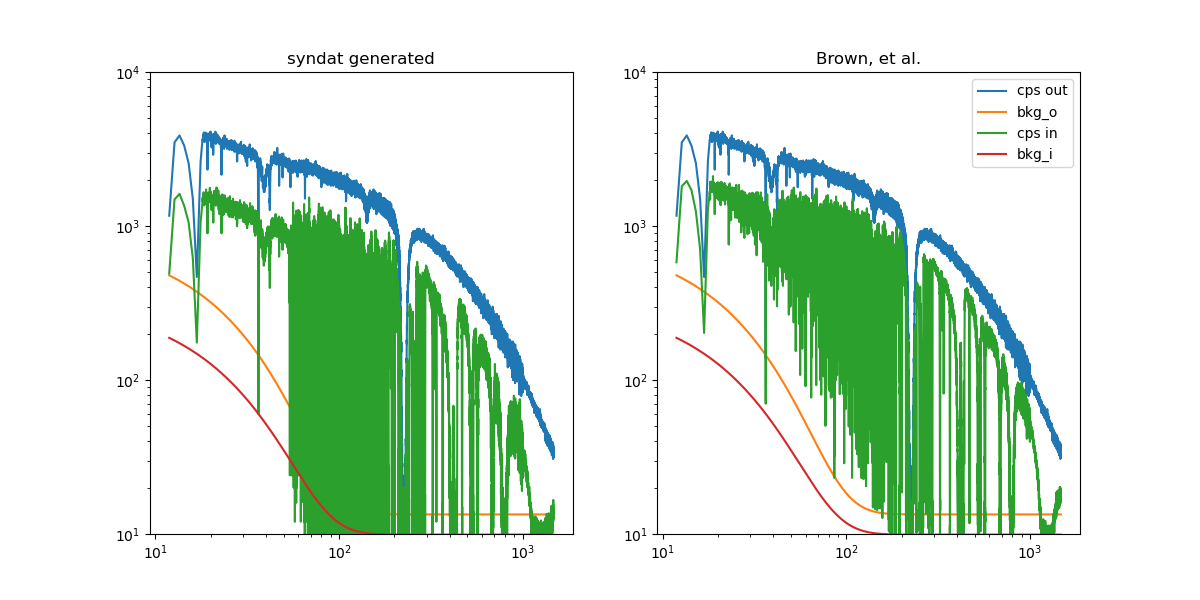

In [86]:
fig, ax = subplots(1,2, figsize=(12,6))

ax[0].plot(syndat_df.tof,syndat_df.co, label='cps out'); 
ax[0].plot(syndat_df.tof, syndat_df.bo, label='bkg_o')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].plot(syndat_df.tof,syndat_df.cs, label='cps in'); 
ax[0].plot(syndat_df.tof, syndat_df.bs, label='bkg_i')
ax[0].set_ylim([10,1e4])
# ax[0].set_xlim([50,2e3])
ax[0].set_title("syndat generated")

ax[1].plot(jb_df.tof,jb_df.co, label='cps out'); 
ax[1].plot(jb_df.tof, jb_df.bo, label='bkg_o')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].plot(jb_df.tof,jb_df.cs, label='cps in'); 
ax[1].plot(jb_df.tof, jb_df.bs, label='bkg_i')
ax[1].set_ylim([10,1e4])
# ax[1].set_xlim([50,2e3])
ax[1].set_title("Brown, et al.")

legend()

(10, 3000.0)

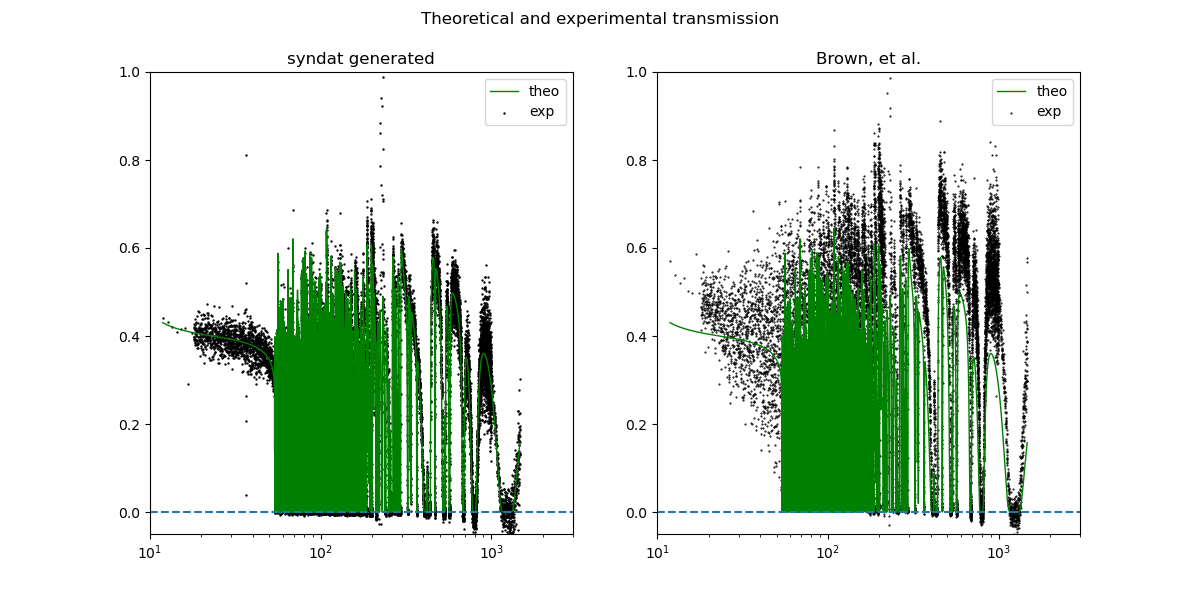

In [96]:

fig,ax = subplots(1,2, figsize=(12,6))
suptitle('Theoretical and experimental transmission')

ax[0].plot(syndat_df.tof,syndat_df.theo, lw=1,c='g', label='theo')
ax[0].scatter(syndat_df.tof,syndat_df.trans, s=0.5, c='k', label='exp')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_ylim([-0.05,1])
ax[0].axhline(y=0.0, ls='--')
ax[0].set_title('syndat generated')

ax[1].plot(syndat_df.tof,syndat_df.theo, lw=1,c='g', label='theo')
ax[1].scatter(jb_df.tof, jb_df.trans, marker='.', color='k', s=1, label='exp')
# ax[1].errorbar(JBrown_lst.tof, JBrown_lst.exp_trans, yerr=JBrown_lst.exp_trans_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3)
ax[1].set_xscale('log')
ax[1].axhline(y=0.0, ls='--')
ax[1].set_ylim([-0.05,1])

ax[1].legend()
ax[1].set_title('Brown, et al.')

ax[0].set_xlim([10,3e3])
ax[1].set_xlim([10,3e3])

# ax[0].set_xlim([175,200])
# ax[1].set_xlim([175,200])

## Compare covariance matrix to Jesse's

This will give insight into whether or not the monitor normalizations have an effect

In [ ]:
# import jesse's covariance 
jb_cov = np.load('../synthetic_data/Ta181/JB_sol/jb_cov.npy')
syndat_cov = experiment.CovT
print(np.shape(syndat_cov))
print(np.shape(jb_cov))


(15915, 15915)
(15915, 15915)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


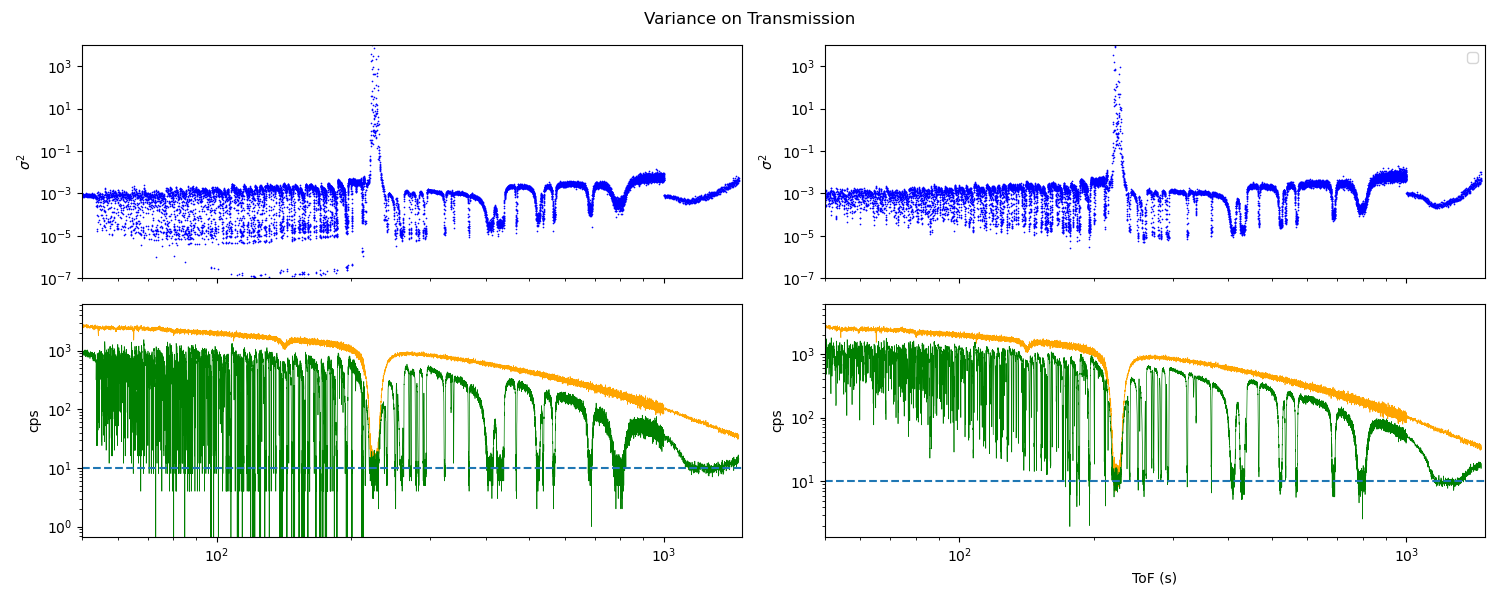

In [121]:
fig, (ax1, ax2) = subplots(2,2, gridspec_kw={'height_ratios': [1, 1]}, sharex=True, figsize=(15,6)) # , figsize=(12,5)

ax1[0].scatter(syndat_df.tof, np.diag(syndat_cov), lw=0.5, color='b', s=0.5, zorder=2)
ax1[0].set_ylim([1e-7,1e4])
ax1[0].set_xlim([50,1.5e3])
ax1[0].set_yscale('log')
ax1[0].set_ylabel('$\sigma^2$'); #('$\sigma$')

ax2[0].plot(syndat_df.tof, syndat_df.co, lw=0.5, c='orange')
ax2[0].plot(syndat_df.tof, syndat_df.cs, lw=0.5, c='g')
# ax[0].set_ylim([0.001,100])
ax2[0].axhline(y=10.0, ls='--')
ax2[0].set_ylabel('cps')
ax2[0].set_yscale('log')


ax1[1].scatter(jb_df.tof, np.diag(jb_cov), lw=0.5, color='b', s=0.5, zorder=2)
ax1[1].set_yscale('log')
ax1[1].set_ylim([1e-7,1e4])
ax1[1].set_xlim([50,1.5e3])
ax1[1].set_ylabel('$\sigma^2$')
ax1[1].legend()

ax2[1].plot(jb_df.tof, jb_df.co, lw=0.5, c='orange')
ax2[1].plot(jb_df.tof, jb_df.cs, lw=0.5, c='g')
# ax[1].set_ylim([0.001,100])
ax2[1].axhline(y=10.0, ls='--')
ax2[1].set_ylabel('cps')
ax2[1].set_yscale('log')


xscale('log')
xlabel('ToF (s)');
suptitle('Variance on Transmission')
tight_layout()


(975, 975)
(975, 975)


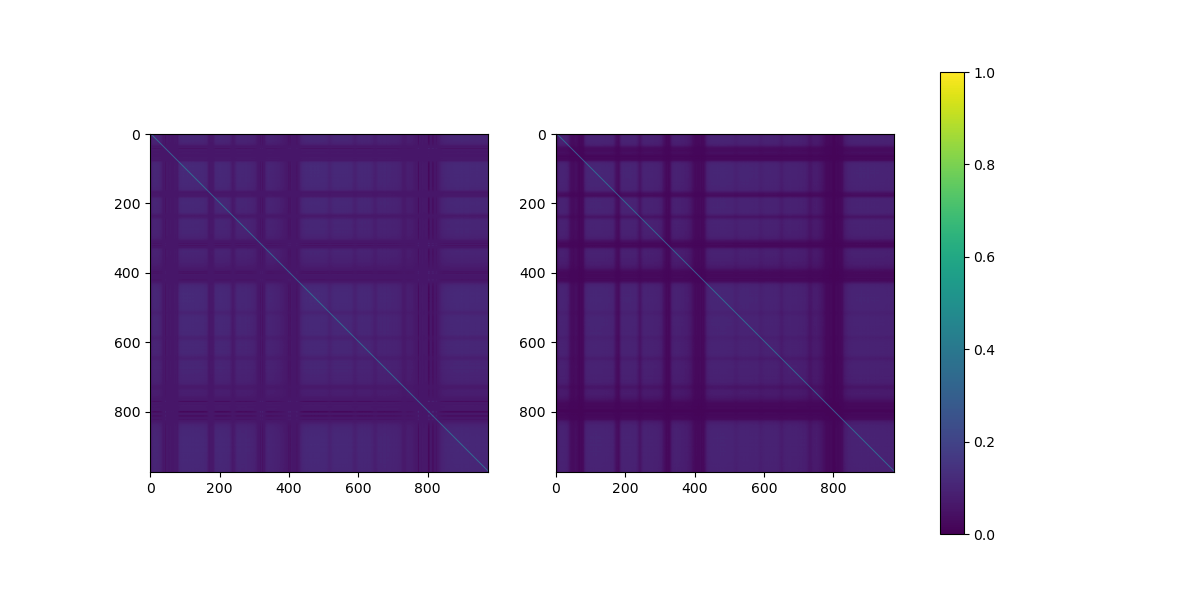

In [76]:
import matplotlib as mpl

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


itof_min = np.argwhere(np.array(syndat_df.tof)>175)[0][0]
itof_max = np.argwhere(np.array(syndat_df.tof)<200)[-1][0]
jb_df_filtered = jb_df[itof_min:itof_max]
syndat_df_filtered = syndat_df[itof_min:itof_max]

jb_cov_filtered = jb_cov[itof_min:itof_max, itof_min:itof_max]
syndat_cov_filtered = syndat_cov[itof_min:itof_max, itof_min:itof_max]
print(np.shape(syndat_cov_filtered))
print(np.shape(jb_cov_filtered)) 


syndat_corr = correlation_from_covariance(syndat_cov_filtered)
jb_corr = correlation_from_covariance(jb_cov_filtered)

fig, ax = subplots(1,2, figsize=(12,6))
ax[0].imshow(syndat_corr)

ax[1].imshow(jb_corr)

# cax = axes([0.85, 0.1, 0.075, 0.8])
colorbar(mpl.cm.ScalarMappable(), ax=ax)

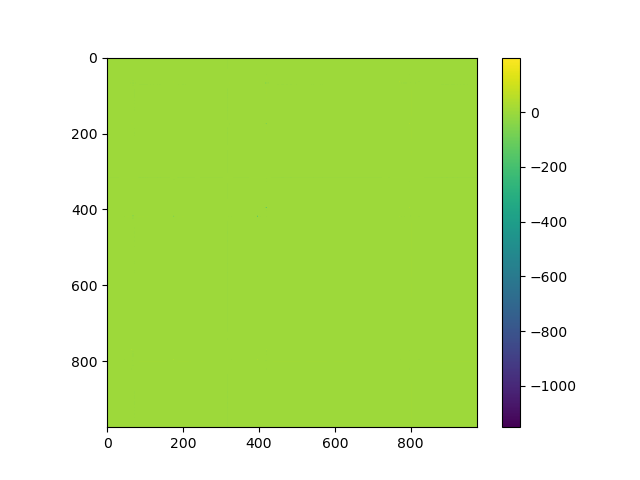

In [125]:
figure()
imshow((jb_cov_filtered-syndat_cov_filtered)/jb_cov_filtered)
colorbar()



In [ ]:
jb_eval, jb_evec = np.linalg.eigh(jb_cov_filtered)
syndat_eval, syndat_evec = np.linalg.eigh(syndat_cov_filtered)


In [81]:
np.shape(jb_evec)

(975,)

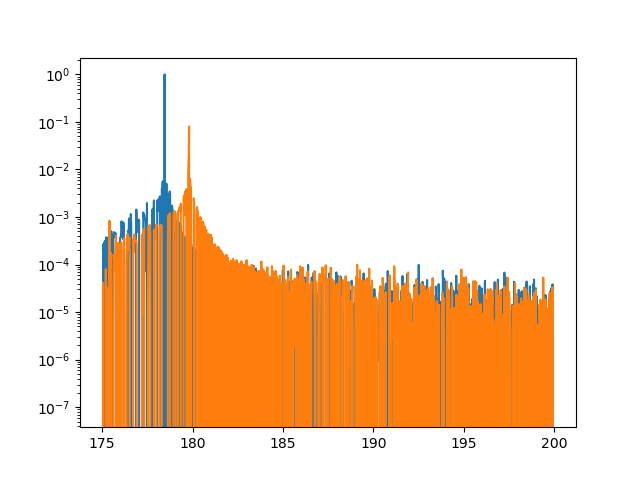

In [95]:
figure()
plot(jb_df_filtered.tof, jb_evec[0])
plot(syndat_df_filtered.tof, syndat_evec[0])
# xscale('log')
yscale('log')